In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import mplhep as hep
hep.style.use("ATLAS")
# sys.path.append("../DataProcessing")
import ReweightMCDataLoading as rmc
sys.path.append("../Plotting")
import Utils as ut

2025-04-04 19:28:12.937704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 19:28:13.066491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 19:28:13.119326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 19:28:13.406271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 19:28:15.271782: W tensorflow/compiler/tf2

In [2]:
# load particle level distributions
aleph_mc = rmc.loadDataParticles(
        filePath = rmc.mc_paths["ArchivedPYTHIA6"]["path"],
        treeName = rmc.mc_paths["ArchivedPYTHIA6"]["tree"],
        branches = rmc.mc_paths["ArchivedPYTHIA6"]["branches"],
        maxNPart = 80,
        padValue = -999
    )
print(aleph_mc.shape)

new_mc_name = "PYTHIA8"
new_mc = rmc.loadDataParticles(
    filePath = rmc.mc_paths[new_mc_name]["path"], 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = rmc.mc_paths[new_mc_name]["branches"],
    maxNPart = 80,
    padValue = -999
)
print(new_mc.shape)

(973769, 80, 3)
(5000000, 80, 3)


In [3]:
thrust_branches = ["Thrust"]

# load thrust distributions
aleph_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths["ArchivedPYTHIA6"]["thrust_path"],
    treeName = rmc.mc_paths["ArchivedPYTHIA6"]["tree"], 
    branches = thrust_branches, 
)
print(aleph_mc_thrust.shape)

new_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths[new_mc_name]["path"].replace(".root", "_thrust.root"), 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = thrust_branches,
)
print(new_mc_thrust.shape)

# convert to log(1-T)
aleph_mc_thrust = np.log(1-aleph_mc_thrust).flatten()
new_mc_thrust = np.log(1-new_mc_thrust).flatten()

(973769, 1)
(5000000, 1)


In [5]:
training_dir = "training-7fd8a490" # "training-03936c4c"
reweight = {}
for i in [1, 2]:
    temp = f"/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/{training_dir}/Reweight_Step{i}.reweight.npy"
    temp = np.load(temp)
    reweight[f"Step{i}"] = temp
    temp = np.tile(temp[:, np.newaxis, np.newaxis], (1, aleph_mc.shape[1], 1))
    reweight[f"Step{i}_tile"] = temp
    print(i, reweight[f"Step{i}"].shape, reweight[f"Step{i}_tile"].shape)

1 (973769,) (973769, 80, 1)
2 (973769,) (973769, 80, 1)


In [6]:
conf = {
    "pmag" : {
        "bins" : np.linspace(0, 50, 51),
        "ax1_ylim" : [10**-5, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$|p|$ [GeV]",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "eta" : {
        "bins" : np.linspace(-5, 5, 51),
        "ax1_ylim" : [10**-4, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\eta$",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "phi" : {
        "bins" : np.linspace(-4, 4, 51),
        "ax1_ylim" : [10**-2, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\phi$",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "thrust" : {
        "bins" : np.linspace(-8, np.log(0.5), 51),
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_ylim" : [0.01, 2.49],
        "ax2_xlabel" : "log(1-T)",
        "legend_loc" : "upper left",
        "legend_bbox" : (0.02, 1),
    }
}

In [7]:
plots = {}

branch = "thrust"
plots[branch] = {}
plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True)
plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight["Step1"])
plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2"])
plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc_thrust, bins=conf[branch]["bins"], density=True)

for iB, branch in enumerate(rmc.mc_paths[new_mc_name]["branches"]):
    plots[branch] = {}
    
    # aleph mc
    mask = aleph_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)
    plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight["Step1_tile"].flatten()[mask])
    plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2_tile"].flatten()[mask])
    # new mc
    mask = new_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: divide by zero encountered in divide
  ratio = A / B


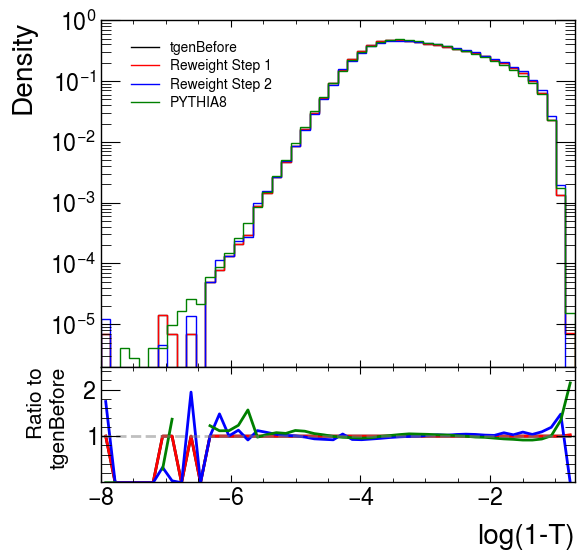

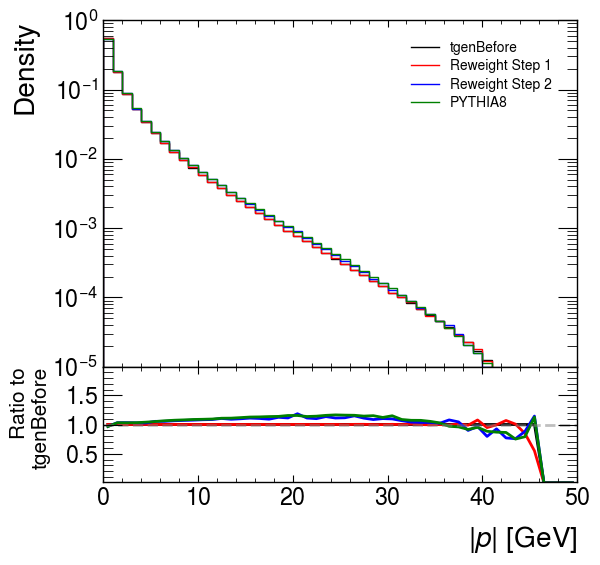

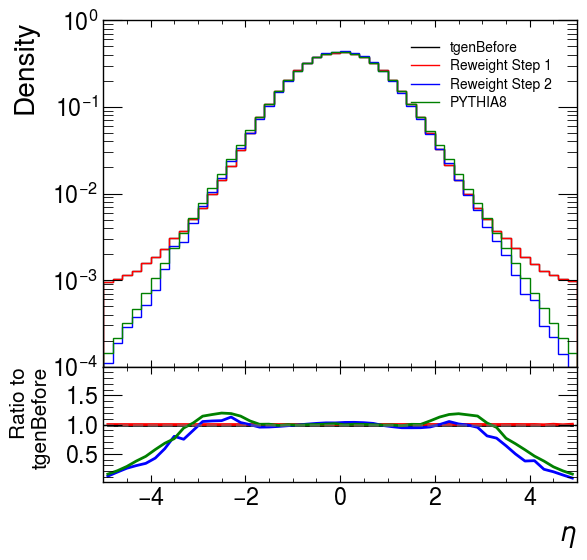

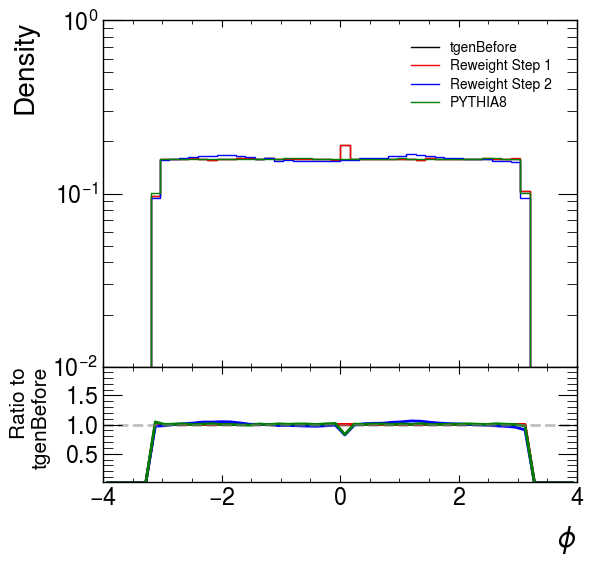

In [8]:
for key, val in plots.items():

    # style
    style = {
        "legend_loc" : conf[key]["legend_loc"],
        "legend_bbox" : conf[key]["legend_bbox"],
        "legend_ncol" : 1,
        "legend_fontsize" : 10,
        "ax1_ylabel" : "Density",
        "ax1_yscale" : "log",
        "ax2_xlabel" : conf[key]["ax2_xlabel"], #f"{key}" + (" [GeV]" if key in ["p"] else ""),
        "ax2_xscale" : "linear",
        "ax2_ylabel" : f'Ratio to\ntgenBefore',
        "ax1_ylim" : conf[key]["ax1_ylim"],
        "bins" : conf[key]["bins"],
        "ax2_ylim" : conf[key]["ax2_ylim"],
    }

    # plot
    inPlots = {}
    inPlots["tgenBefore"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc"][0], "color": "black", "label": "tgenBefore", "ls":"-"}
    inPlots["tgenBefore_rw_step1"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step1"][0], "color": "red", "label": "Reweight Step 1", "ls":"-"}
    inPlots["tgenBefore_rw_step2"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step2"][0], "color": "blue", "label": "Reweight Step 2", "ls":"-"}
    inPlots["new_mc"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_new_mc"][0], "color": "green", "label": new_mc_name, "ls":"-"}

    # ratio denominator using the total error
    ratio_denom = [val["h_aleph_mc"]]

    fig, (ax1, ax2) = ut.plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
    plt.show()
    plt.close()